In [1]:
from pycocotools.coco import COCO

import gc
import re
import os
import cv2
import json
import time
import numpy as np
from PIL import Image
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
if os.path.exists('logfile.log'):
    os.remove('logfile.log')

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

file_handler = logging.FileHandler('logfile.log')
console_handler = logging.StreamHandler()

formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

logger.handlers.clear()

logger.addHandler(file_handler)
logger.addHandler(console_handler)

In [3]:
data_path = '/kaggle/input/coco-2017-dataset'
FOLDER_PATH = os.path.join(data_path, 'coco2017/')
MODEL_FOLDER = 'models'
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)

IMAGE_SIZE = 224
NUM_WORKER = os.cpu_count()
learning_rate=1e-3
epochs = 6
patience = 3
counter = 0

if torch.cuda.is_available():
    BATCH_SIZE = 8
    device = torch.device("cuda")
else:
    BATCH_SIZE = 128
    device = torch.device("cpu")

logger.info(f'Device using: {device}')
logger.info(f'CPU Count: {NUM_WORKER}')

Device using: cuda
CPU Count: 4


In [4]:
def clean_json(json_path, image_root, save_path=None):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    valid_images = []
    valid_ids = set()
    for img in tqdm(data['images']):
        img_url = img['coco_url']
        img_name = os.path.basename(img_url)
        img_path = os.path.join(image_root, img_name)
        
        if os.path.exists(img_path):
            valid_images.append(img)
            valid_ids.add(img['id'])
    valid_annotations = [ann for ann in data['annotations'] if ann['image_id'] in valid_ids]

    cleaned_data = {
        "images": valid_images,
        "annotations": valid_annotations,
        "categories": data["categories"]
    }
    logger.info(f'From {len(data["images"])} to {len(cleaned_data["images"])}')
    if save_path is None:
        save_path = 'cleaned.json'
    with open(save_path, 'w') as f:
        json.dump(cleaned_data, f)

    logger.info(f"Saved cleaned file to {save_path}")
    return cleaned_data
clean = False
if clean:
    clean = clean_json('/kaggle/input/lvis-v1/lvis_v1_val/lvis_v1_val.json', '/kaggle/input/lvis-v1/lvis_v1_val/val2017')

In [6]:
class CustomDataset(Dataset):
    def __init__(self, coco_root, coco_ann, lvis_root, lvis_ann, transform=None):
        self.coco = None
        self.lvis = None
        if coco_root:
            self.coco = COCO(coco_ann)
            self.coco_ids = list(self.coco.imgs.keys())
        if lvis_root:
            self.lvis = COCO(lvis_ann)
            self.lvis_ids = list(self.lvis.imgs.keys())
        
        if coco_root and lvis_root:
            self.ids = self.coco_ids + self.lvis_ids
            self.sources = ["coco"] * len(self.coco_ids) + ["lvis"] * len(self.lvis_ids)
            all_cat_ids = sorted(set(self.coco.getCatIds()) | set(self.lvis.getCatIds()))
        elif coco_root is None:
            self.ids = self.lvis_ids
            self.sources = ["lvis"] * len(self.lvis_ids)
            all_cat_ids = sorted(set(self.lvis.getCatIds()))
        elif lvis_root is None:
            self.ids = self.coco_ids
            self.sources = ["coco"] * len(self.coco_ids)
            all_cat_ids = sorted(set(self.coco.getCatIds()))

        self.roots = {"coco": coco_root, "lvis": lvis_root}
        self.transform = transform

        self.cat_id_map = {cat_id: i + 1 for i, cat_id in enumerate(all_cat_ids)}
        self.index = -1

    def __len__(self):
        return len(self.ids)

    def get_img_path(self, source: str, img_info):
        if source == "coco":
            img_path = os.path.join(self.roots[source], img_info["file_name"])
        else:  # Assuming 'source' is 'lvis'
            img_url = img_info.get('coco_url', img_info.get('flickr_url', ''))
            img_name = os.path.basename(img_url)
            img_path = os.path.join(self.roots[source], img_name)
        return img_path

    def __getitem__(self, index):
        source = self.sources[index]
        img_id = self.ids[index]

        coco_api = self.coco if source == "coco" else self.lvis
        img_info = coco_api.loadImgs(img_id)[0]
        ann_ids = coco_api.getAnnIds(imgIds=img_id)
        annotations = coco_api.loadAnns(ann_ids)
        
        img_path = self.get_img_path(source, img_info)
        image = cv2.imread(img_path)
        if image is None:
            logger.error(f'Error reading at: {img_path}')
            return self.__getitem__(self.index)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint16)
        for ann in annotations:
            ann_mask = coco_api.annToMask(ann)
            mask = np.maximum(mask, ann_mask)


        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
            
        self.index = index
        return image, mask.long()
    def get_num_classes(self):
        cat_ids_coco = self.coco.getCatIds() if self.coco else []
        cat_ids_lvis = self.lvis.getCatIds() if self.lvis else []
        all_cat_ids = sorted(set(cat_ids_coco) | set(cat_ids_lvis))
        return len(all_cat_ids) + 1

# Augmentations
train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Load datasets
coco_train = CustomDataset(
    coco_root=os.path.join(FOLDER_PATH, "train2017"),
    coco_ann=os.path.join(FOLDER_PATH, "annotations/instances_train2017.json"),
    lvis_root='/kaggle/input/lvis-v1/train2017/train2017',
    lvis_ann='/kaggle/input/lvis-v1/lvis_v1_train.json/lvis_v1_train.json',
    transform=train_transform
)

lvis_val_train = CustomDataset(
    coco_root=None,
    coco_ann=None,
    lvis_root='/kaggle/input/lvis-v1/lvis_v1_val/val2017',
    lvis_ann='cleaned.json',
    transform=train_transform
)

train_dataset = ConcatDataset([coco_train, lvis_val_train])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)

val_dataset = CustomDataset(
    coco_root=os.path.join(FOLDER_PATH, "val2017"), 
    coco_ann=os.path.join(FOLDER_PATH, "annotations/instances_val2017.json"), 
    lvis_root=None,
    lvis_ann=None,
    transform=val_transform
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER)

loading annotations into memory...
Done (t=20.31s)
creating index...
index created!
loading annotations into memory...
Done (t=30.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [7]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.LeakyReLU(0.01, inplace=True)

    def forward(self, g, x):  # g: decoder, x: encoder
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(DoubleConv, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout2d(p=0.5))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=91):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024, dropout=True)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionGate(512, 512, 256)
        self.dec4 = DoubleConv(1024, 512, dropout=True)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = DoubleConv(512, 256, dropout=True)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionGate(128, 128, 64)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionGate(64, 64, 32)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        up4 = self.up4(bottleneck)
        enc4_att = self.att4(up4, enc4)
        dec4 = self.dec4(torch.cat([up4, enc4_att], dim=1))

        up3 = self.up3(dec4)
        enc3_att = self.att3(up3, enc3)
        dec3 = self.dec3(torch.cat([up3, enc3_att], dim=1))

        up2 = self.up2(dec3)
        enc2_att = self.att2(up2, enc2)
        dec2 = self.dec2(torch.cat([up2, enc2_att], dim=1))

        up1 = self.up1(dec2)
        enc1_att = self.att1(up1, enc1)
        dec1 = self.dec1(torch.cat([up1, enc1_att], dim=1))

        return self.final(dec1)

In [8]:
model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_unet = os.path.join(MODEL_FOLDER,'best_model.pth')
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

In [9]:
paths = os.listdir(MODEL_FOLDER)
model_list = sorted([path for path in paths if path.endswith('.pth')])
epoch_models = [(int(re.search(r'(\d+)', model).group()), model) for model in model_list if re.search(r'model_epoch_(\d+)\.pth', model)]
if len(epoch_models) < 1:
    latest_model = 0
else:
    latest_model = max(epoch_models, key=lambda x: x[0])[1]
using_best = True
if using_best:
    model_path = best_unet
else:
    model_path = os.path.join(MODEL_FOLDER, str(latest_model))
logger.info(f'Lastest model: {latest_model}')
logger.info(f'Model using: {model_path}')

Lastest model: model_epoch_14.pth
Model using: models/best_model.pth


In [10]:
if os.path.exists(model_path):
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path, weights_only=True))
    else:
        model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
    model.to(device)
    logger.info(f"Model loaded successfully on {device}")
else:
    logger.info(f"Error: Model path '{model_path}' does not exist.")

Model loaded successfully on cuda


In [11]:
def calculate_dice(pred_mask, true_mask, num_classes=91):
    dice_scores = []
    for cls in range(1, num_classes):
        pred_cls = (pred_mask == cls).float()
        true_cls = (true_mask == cls).float()

        intersection = (pred_cls * true_cls).sum()
        denom = pred_cls.sum() + true_cls.sum()
        if denom == 0:
            continue
        dice = (2.0 * intersection) / (denom + 1e-6)
        dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

def train(model: UNet, 
          train_loader: DataLoader, 
          optimizer: optim.Adam, 
          criterion: nn.CrossEntropyLoss, 
          device: torch.device):
    model.train()
    
    dice_scores, running_loss = [], []
    min_dice, max_dice = 1, 0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        preds = torch.argmax(outputs, dim=1)
        dice = calculate_dice(preds, masks)
        dice_scores.append(dice)

        min_loss = float(min(running_loss))
        max_loss = float(max(running_loss))
        
        min_dice = float(min(dice, min_dice))
        max_dice = float(max(dice, max_dice))
        
        loop.set_postfix(loss=loss.item(),
                         min_loss = min_loss,
                         max_loss = max_loss,
                         min_dice = min_dice,
                         max_dice = max_dice,
                         dice = dice)

    return np.array(running_loss), np.array(dice_scores)

def validate(model: UNet, 
             val_loader: DataLoader, 
             criterion: nn.CrossEntropyLoss, 
             device: torch.device):  
    model.eval()
    dice_scores, val_losses = [], []

    loop = tqdm(val_loader, desc="Evaluating", leave=False)
    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        loss = criterion(outputs, masks)
        dice = calculate_dice(preds, masks)
        
        val_losses.append(loss.item())
        dice_scores.append(dice)

        loop.set_postfix(loss=loss.item())

    return np.array(val_losses), np.array(dice_scores)

In [12]:
if torch.cuda.is_available() and os.path.exists(model_path):
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    val_loss_mean = np.mean(val_loss)
    val_dice_mean = np.mean(val_dice)
    
    best_dice_mean = val_dice_mean

    logger.info(f"Val Loss: {val_loss_mean:.4f} - "
          f"Val Dice: {val_dice_mean:.4f}")
else:
    best_dice_mean = 0.6351

Val Loss: 0.3256 - Val Dice: 0.7246                                       


In [15]:
logger.info(f'Dice: {best_dice_mean:.4f}')
logger.info(f'Object Released: {gc.collect()}')

Dice: 0.7246
Object Released: 0


In [ ]:
train_loss_history = []
train_dice_history = []
val_loss_history = []
val_dice_history = []
for epoch in range(epochs):
    logger.info('=' * 25 + f'Epoch {epoch + 1}/ {epochs}' + '=' * 25)
    start_time = time.time()

    # Train the model and get the metrics
    train_loss, train_dice = train(model, train_loader, optimizer, criterion, device)
    # Validate the model and get the metrics
    val_loss, val_dice = validate(model, val_loader, criterion, device)

    epoch_time = time.time() - start_time
    
    # Compute min, max, and mean for train and val metrics
    train_loss_min = np.min(train_loss)
    train_loss_max = np.max(train_loss)
    train_loss_mean = np.mean(train_loss)

    train_dice_min = np.min(train_dice)
    train_dice_max = np.max(train_dice)
    train_dice_mean = np.mean(train_dice)

    val_loss_min = np.min(val_loss)
    val_loss_max = np.max(val_loss)
    val_loss_mean = np.mean(val_loss)
    
    val_dice_min = np.min(val_dice)
    val_dice_max = np.max(val_dice)
    val_dice_mean = np.mean(val_dice)
    
    logger.info(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss_mean:.4f} (min: {train_loss_min:.4f}, max: {train_loss_max:.4f}), "
          f"Val Loss: {val_loss_mean:.4f} (min: {val_loss_min:.4f}, max: {val_loss_max:.4f}) - "
          f"Train Dice: {train_dice_mean:.4f} (min: {train_dice_min:.4f}, max: {train_dice_max:.4f}), "
          f"Val Dice: {val_dice_mean:.4f} (min: {val_dice_min:.4f}, max: {val_dice_max:.4f}) - "
          f"Time: {epoch_time:.2f}s - Release: {gc.collect()} objects")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        
    if val_dice_mean > best_dice_mean:
        best_dice_mean = val_dice_mean
        counter = 0
        torch.save(model.state_dict(), os.path.join(MODEL_FOLDER, 'best_model.pth'))
        logger.info(f"Saved new Best Model! -  Loss: {val_loss_mean:.4f}, Dice {val_dice_mean:.4f}")
    else:
        counter += 1
        logger.info(f"Early Stopping Counter: {counter}/{patience}")
    
    # Save the model with the current epoch
    saved_models = [f for f in os.listdir(MODEL_FOLDER) if re.match(r'model_epoch_\d+\.pth', f)]
    max_epoch = 0
    if saved_models:
        max_epoch = max(int(re.search(r'model_epoch_(\d+)\.pth', f).group(1)) for f in saved_models)
    
    next_epoch = max_epoch + 1
    torch.save(model.state_dict(), os.path.join(MODEL_FOLDER, f"model_epoch_{next_epoch}.pth"))
    logger.info(f"Saved Model: model_epoch_{next_epoch}.pth")
    
    if counter >= patience:
        logger.info("Early stopping triggered! Training stopped.")
        break

    # Append the metrics to the history lists
    train_loss_history.append(np.mean(train_loss))
    train_dice_history.append(np.mean(train_dice))
    val_loss_history.append(np.mean(val_loss))
    val_dice_history.append(np.mean(val_dice))
    
    lr_scheduler.step()

=========================Epoch 1/ 6=========================
Epoch 1/6 - Train Loss: 0.3681 (min: 0.1233, max: 1.1499), Val Loss: 0.3218 (min: 0.0807, max: 0.6889) - Train Dice: 0.6354 (min: 0.1409, max: 0.9214), Val Dice: 0.7346 (min: 0.3570, max: 0.9194) - Time: 6527.78s - Release: 0 objects
Saved new Best Model! -  Loss: 0.3218, Dice 0.7346
Saved Model: model_epoch_1.pth
=========================Epoch 2/ 6=========================
Epoch 2/6 - Train Loss: 0.3652 (min: 0.1148, max: 1.2803), Val Loss: 0.3283 (min: 0.0946, max: 0.7159) - Train Dice: 0.6384 (min: 0.1459, max: 0.9352), Val Dice: 0.7138 (min: 0.4050, max: 0.9377) - Time: 6526.08s - Release: 0 objects
Early Stopping Counter: 1/3
Saved Model: model_epoch_2.pth
=========================Epoch 3/ 6=========================
Training:  87%|████████▋ | 24390/27909 [1:33:58<13:33,  4.32it/s, dice=0.649, loss=0.439, max_dice=0.92, max_loss=0.998, min_dice=0.0604, min_loss=0.102] IOPub message rate exceeded.
The notebook server will 

In [20]:
logger.info(f'Dice: {best_dice_mean:.4f}')
logger.info(f'Object Released: {gc.collect()}')

Dice: 0.7457
Object Released: 14899


In [ ]:
val_loss, val_dice = validate(model, val_loader, criterion, device)
val_loss_mean = np.mean(val_loss)
val_dice_mean = np.mean(val_dice)

best_dice_mean = max(best_dice_mean, val_dice_mean)

logger.info(f"Val Loss: {val_loss_mean:.4f} - ", 
      f"Val Dice: {val_dice_mean:.4f}")

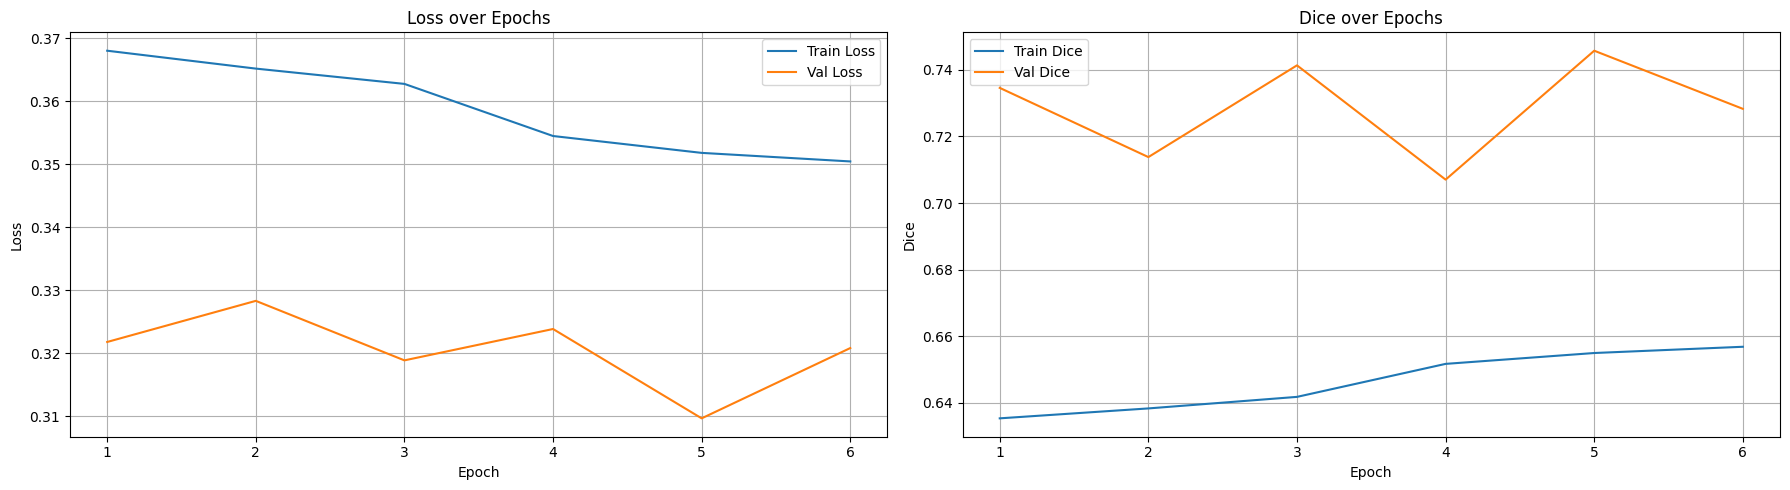

In [19]:
r = list(range(1, epochs + 1))

plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(r, train_loss_history, label='Train Loss')
plt.plot(r, val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Dice
plt.subplot(1, 2, 2)
plt.plot(r, train_dice_history, label='Train Dice')
plt.plot(r, val_dice_history, label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('history.png')
plt.show()